In [7]:
import scipy
import numpy as np
from scipy.special import kn
from scipy.constants import c, hbar, k, pi
import matplotlib.pyplot as plt
%matplotlib widget

In [ ]:
# convert the following fortran code to python:
# ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
# 	subroutine ninu1(a,rhonu,pnu,amnu)
# c  Compute the density and pressure of one flavor of massive neutrinos,
# c  in units of the mean density of one flavor of massless neutrinos.
# c  Relative accuracy is better than 1.e-10 for all a.
# c
# 	implicit double precision (a-h,o-z)
# c
# c	common /cosmoparm/ ak,ak2,amnu,lmax,lmaxnr,lmaxnu,
# c     &                              nqmax,iq0,iq1,iq2
# c
# 	parameter (qmax=30.0d0,nq=1000,nq1=nq+1)
# 	dimension dum1(nq1),dum2(nq1)
# c  const=7*pi**4/120.
# 	parameter (const=5.68219698d0)
# c
# 	if (amnu.eq.0.0d0) then
# 	  rhonu=1.0d0
# 	  pnu=1.0d0/3.0d0
# 	  return
# 	end if
# c
# c  q is the comoving momentum in units of k_B*T_nu0/c.
# c  Integrate up to qmax and then use asymptotic expansion for remainder.
# 	dq=qmax/nq
# 	dum1(1)=0.0d0
# 	dum2(1)=0.0d0
# 	  do 10 i=1,nq
# 	  q=i*dq
# 	  aq=a*amnu/q
# 	  v=1.0d0/sqrt(1.0d0+aq*aq)
# 	  qdn=dq*q*q*q/(exp(q)+1.0d0)
# 	  dum1(i+1)=qdn/v
# 	  dum2(i+1)=qdn*v
# 10	continue
# 	call splint(dum1,rhonu,nq1)
# 	call splint(dum2,pnu,nq1)
# c  Apply asymptotic corrrection for q>qmax and normalize by relativistic
# c  energy density.
# 	rhonu=(rhonu+dum1(nq1)/dq)/const
# 	pnu=(pnu+dum2(nq1)/dq)/const/3.0d0
# c
# 	return
# 	end

In [37]:
Tcmb = 2.7255
H0 = 67.66
h = H0/100

def Omega_nu_(a, mnu):
    # a is the scale factor
    # Tcmb is the temperature of the CMB
    # H0 is the Hubble constant
    # h is the reduced Hubble constant
    # Omega_nu is the density of neutrinos
    # Omega_nu = 7*pi^4/120 * (T_nu/T_cmb)^4 * (4/11)^(4/3) * (1/1.68)
    sum = 0.0
    for m in mnu:
        c2ok = 1.62581581e4 # K / eV
        beta = m/Tcmb * c2ok
        def integ(y):
            return y**2 * np.sqrt(1+y**2/a**2) / (np.exp(beta*y) + 1)
        res = scipy.integrate.quad(integ, 0, np.inf)
        sum += res[0] * (m/5.32e-3)**4
    return sum * a**-3

def Omega_nu( a, mnu ):
    res = np.zeros_like(a)
    for i, ai in enumerate(a):
        res[i] = Omega_nu_(ai, mnu)
    return res


In [34]:
# write a function that computes the neutrino density and pressure
# in units of the mean density of one flavor of massless neutrinos
# as a function of the scale factor a, the neutrino mass amnu,
# and infer the number of neutrino species nnu from the length of amnu.
# use the function splint from scipy.interpolate to perform the integration
# and the asymptotic expansion for large q.
def ninu1(a : float, amnu: float, nq : int = 1000, qmax : float = 30.) -> tuple[float, float]:
    # compute the neutrino density and pressure
    # in units of the mean density of one flavor of massless neutrinos
    # as a function of the scale factor a, the neutrino mass amnu,
    # and infer the number of neutrino species nnu from the length of amnu.
    # use the function splint from scipy.interpolate to perform the integration
    # and the asymptotic expansion for large q.
    rhonu = np.zeros_like(a)
    pnu = np.zeros_like(a)
    # const = 7 * np.pi**4 / 120
    const = 5.68219698
    nq1 = nq + 1
    dq = qmax / nq
    dum1 = np.zeros(nq1)
    dum2 = np.zeros(nq1)
    q    = np.linspace(1e-8, qmax, nq1)
    if amnu == 0:
        rhonu = 1
        pnu = 1 / 3
        return rhonu, pnu

    aq = a * amnu / q
    v = 1 / np.sqrt(1 + aq**2)
    qdn = dq * q**3 / (np.exp(q) + 1)
    dum1 = qdn / v
    dum2 = qdn * v
    rho_tck = scipy.interpolate.splrep(q, dum1)
    p_tck = scipy.interpolate.splrep(q, dum2)
    
    rhonu = scipy.interpolate.splint(0.0, qmax, rho_tck )
    pnu = scipy.interpolate.splint(0.0, qmax, p_tck )
    rhonu = (rhonu + dum1[-1] / dq) / const
    pnu = (pnu + dum2[-1] / dq) / const / 3
    return rhonu, pnu


In [35]:
aa = np.geomspace(1e-5,1.0,100)
rhonu = np.zeros_like(aa)

for i,a in enumerate(aa):
  rhonu[i],_ = ninu1(a, 0.01)

Energy density of 

/var/folders/m8/1yjz77r957vbsrx_2s2hdj1r0000gn/T/ipykernel_3346/567963105.py:17: RuntimeWarning: overflow encountered in exp
  return y**2 * np.sqrt(1+y**2/a**2) / (np.exp(beta*y) + 1)


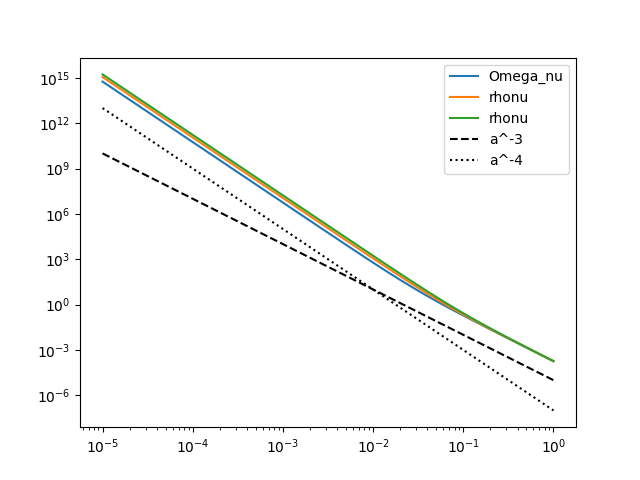

In [38]:
fig, ax = plt.subplots()
ax.loglog(aa, Omega_nu(aa, [0.017]), label='Omega_nu')
ax.loglog(aa, Omega_nu(aa, [0.01,0.007]), label='rhonu')
ax.loglog(aa, Omega_nu(aa, [0.01,0.006,0.001]), label='rhonu')
ax.loglog(aa,1e-5*aa**-3, c='k', ls='--', label='a^-3')
ax.loglog(aa,1e-7*aa**-4, c='k', ls=':', label='a^-4')
ax.legend()

In [ ]:
# very fast numerical integration of the neutrino distribution function in jax
# using the trapezoidal rule and the asymptotic expansion for large q
def ninu2(a,amnu):
    

In [32]:
def Omega_nu( a, mnu ):
    """
    Computes the neutrino density parameter Omega_nu for a given scale factor a and neutrino mass mnu
    a: scale factor
    mnu: neutrino mass in eV
    """
    T_CMB = 2.7255 # K
    T = T_CMB/a
    k = 8.6173303e-5 # eV/K
    hbar = 6.58211928e-16 # eV*s
    H0 = 2.2685455e-18 # 1/s
    c = 299792458 # m/s
    Omega_nu = 0.0
    for i in range(3):
        Omega_nu += 2*7*pi/960*(mnu[i]/(k*T))**2*kn(2,mnu[i]/(k*T))
    Omega_nu *= k**4*T**4/hbar**3/c**2/c**2/c/H0**2
    return Omega_nu

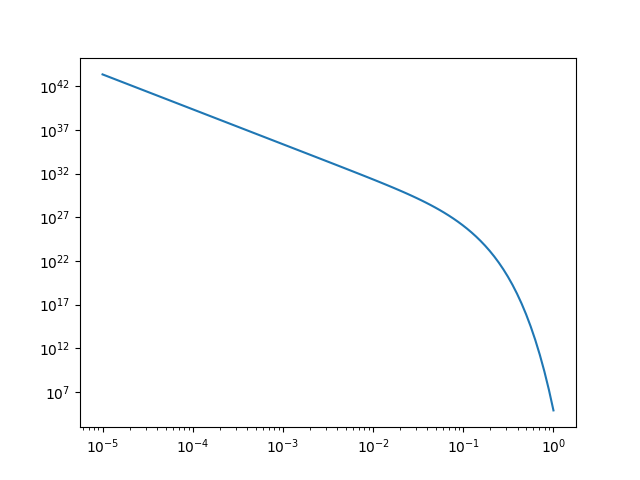

In [33]:
fig, ax = plt.subplots()
aa = np.geomspace(1e-5,1.0,100)
ax.loglog(aa, Omega_nu(aa, [0.017,0.013,0.011]), label='Omega_nu')